In [1]:
from google.colab import drive

drive.mount('/content/drive/')

path = './drive/MyDrive/Data/'

data_path = path + 'book_data.csv'
glove_path = path + 'glove.6B.100d.txt'

Mounted at /content/drive/


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

In [3]:
data = pd.read_csv(data_path)
data.head()

,Title,Category,Image,Rating,Description,UPC,Product Type,Price (excl. tax),Price (incl. tax),Tax,Availability,Number of reviews
0,A Light in the Attic,Poetry,https://books.toscrape.com/media/cache/fe/72/f...,Three,It's hard to imagine a world without A Light i...,a897fe39b1053632,Books,Â£51.77,Â£51.77,Â£0.00,In stock (22 available),0
1,Tipping the Velvet,Historical Fiction,https://books.toscrape.com/media/cache/08/e9/0...,One,"""Erotic and absorbing...Written with starling ...",90fa61229261140a,Books,Â£53.74,Â£53.74,Â£0.00,In stock (20 available),0
2,Soumission,Fiction,https://books.toscrape.com/media/cache/ee/cf/e...,One,"Dans une France assez proche de la nÃ´tre, un ...",6957f44c3847a760,Books,Â£50.10,Â£50.10,Â£0.00,In stock (20 available),0
3,Sharp Objects,Mystery,https://books.toscrape.com/media/cache/c0/59/c...,Four,"WICKED above her hipbone, GIRL across her hear...",e00eb4fd7b871a48,Books,Â£47.82,Â£47.82,Â£0.00,In stock (20 available),0
4,Sapiens: A Brief History of Humankind,History,https://books.toscrape.com/media/cache/ce/5f/c...,Five,From a renowned historian comes a groundbreaki...,4165285e1663650f,Books,Â£54.23,Â£54.23,Â£0.00,In stock (20 available),0


In [4]:
df = data.copy()

df = df.iloc[:, 3:5]

df.head()

,Rating,Description
0,Three,It's hard to imagine a world without A Light i...
1,One,"""Erotic and absorbing...Written with starling ..."
2,One,"Dans une France assez proche de la nÃ´tre, un ..."
3,Four,"WICKED above her hipbone, GIRL across her hear..."
4,Five,From a renowned historian comes a groundbreaki...


In [5]:
df['Rating'] = df['Rating'].map({
    'One':0,
    'Two':1,
    'Three':2,
    'Four':3,
    'Five':4
})

df = df.dropna()

df = df.reset_index(drop=True)

df.head()

,Rating,Description
0,2,It's hard to imagine a world without A Light i...
1,0,"""Erotic and absorbing...Written with starling ..."
2,0,"Dans une France assez proche de la nÃ´tre, un ..."
3,3,"WICKED above her hipbone, GIRL across her hear..."
4,4,From a renowned historian comes a groundbreaki...


<Axes: >

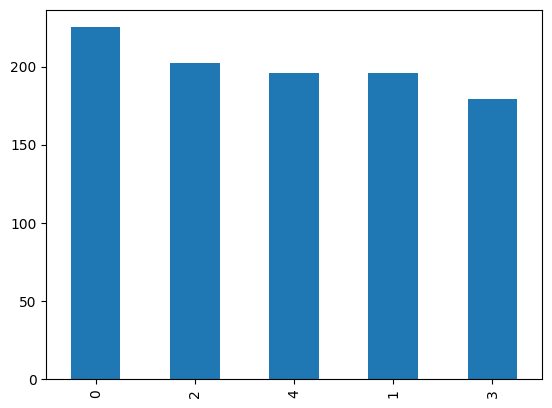

In [6]:
df['Rating'].value_counts().plot(kind='bar')

In [7]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 73.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 59.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 32.9 MB/s eta 0:00:00


In [8]:
from transformers import pipeline

model_name = "eleldar/language-detection"

pipe = pipeline("text-classification", model=model_name)

In [10]:
en_df = pd.DataFrame(columns=['Rating', 'Description'])

for index in range(len(df)):

    sentence = df['Description'][index]

    if len(sentence) > 500:
      sentence = sentence[:500]
      language = pipe(sentence)[0]['label']
    else:
      language = pipe(sentence)[0]['label']

    if language == 'en':
      en_df.loc[len(en_df)] = [df['Rating'][index], df['Description'][index]]


In [11]:
contractions = {
    r"'m": " am",
    r"'s": ' is',
    r"isn't": "isnot",
    r"'re": " are",
    r"aren't": "arenot",
    r"'ve": " have",
    r"haven't": "havenot",
    r"hasn't": "hasnot",
    r"don't": "donot",
    r"doesn't": "doesnot",
    r"didn't": "didnot",
    r"can't": "cannot",
    r"won't": "willnot",
    r"'ll": " will",
    r"shouldn't": "shouldnot",
    r"wouldn't": "wouldnot",
}

def remove_contractions(text):
  for pattern, replacement in contractions.items():
    text = re.sub(pattern, replacement, text, flags=re.IGNORECASE)
  return text

In [12]:
def preprocessing(Description):
  sentence = remove_contractions(Description)
  sentence = re.sub(r'[^a-zA-Z]', ' ', sentence)
  sentence = ' '.join(word.lower() for word in sentence.split())
  return sentence

en_df['Description'] = en_df['Description'].apply(preprocessing)

en_df.head()

,Rating,Description
0,2,it is hard to imagine a world without a light ...
1,0,erotic and absorbing written with starling pow...
2,3,wicked above her hipbone girl across her heart...
3,4,from a renowned historian comes a groundbreaki...
4,0,patient twenty nine a monster roams the halls ...


In [13]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [14]:
en_stopwords = stopwords.words('english')

def clean_stopwords(Description):
  words = Description.split()
  sentence = ' '.join(word for word in words if word not in en_stopwords)
  return sentence

en_df['Description'] = en_df['Description'].apply(clean_stopwords)

en_df.head()

,Rating,Description
0,2,hard imagine world without light attic classic...
1,0,erotic absorbing written starling power new yo...
2,3,wicked hipbone girl across heart words like ro...
3,4,renowned historian comes groundbreaking narrat...
4,0,patient twenty nine monster roams halls soothi...


In [23]:
X = en_df['Description']
y = en_df['Rating']

y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y, shuffle=True
)

In [24]:
tokenizer = Tokenizer(num_words=20000)

tokenizer.fit_on_texts(X_train)

X_train_tokenized = tokenizer.texts_to_sequences(X_train)
X_test_tokenized = tokenizer.texts_to_sequences(X_test)

num_tokens = np.array([len(x) for x in X_train_tokenized + X_test_tokenized])

max_token = int(num_tokens.mean() + 2 * num_tokens.std())

print('max_token :', max_token)

X_train_padded = pad_sequences(X_train_tokenized, maxlen=max_token)
X_test_padded = pad_sequences(X_test_tokenized, maxlen=max_token)

max_token : 256


In [25]:
glove_matrix = {}

with open(glove_path, 'r', encoding='utf-8') as f:
  lines = f.readlines()

for line in lines:
  parts = line.split()
  word = parts[0]
  vectors = [float(vec) for vec in parts[1:]]
  glove_matrix[word] = vectors

embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 100))

for word, index in tokenizer.word_index.items():
  vector = glove_matrix.get(word)

  if vector is not None:
    embedding_matrix[index] = vector

In [34]:
def lstm_model(hidded_state_acfun, optimizer):
  model = Sequential()

  model.add(Embedding(
      input_dim=len(tokenizer.word_index)+1,
      output_dim=100,
      weights=[embedding_matrix],
      input_length=max_token,
      trainable=True
  ))

  model.add(LSTM(units=256, activation=hidded_state_acfun, return_sequences=True))
  model.add(LSTM(units=128, activation=hidded_state_acfun, return_sequences=True))
  model.add(LSTM(units=64, activation=hidded_state_acfun, return_sequences=True))
  model.add(LSTM(units=32, activation=hidded_state_acfun, return_sequences=True))
  model.add(LSTM(units=16, activation=hidded_state_acfun, return_sequences=True))

  model.add(LSTM(units=8, activation=hidded_state_acfun, return_sequences=False))

  model.add(Dense(y.shape[1], activation='softmax'))

  model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

  print(model.summary())

  return model

In [35]:
model = lstm_model(hidded_state_acfun='tanh', optimizer='adam')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 256, 100)          1677200   
                                                                 
 lstm_18 (LSTM)              (None, 256, 256)          365568    
                                                                 
 lstm_19 (LSTM)              (None, 256, 128)          197120    
                                                                 
 lstm_20 (LSTM)              (None, 256, 64)           49408     
                                                                 
 lstm_21 (LSTM)              (None, 256, 32)           12416     
                                                                 
 lstm_22 (LSTM)              (None, 256, 16)           3136      
                                                                 
 lstm_23 (LSTM)              (None, 8)                

In [36]:
model.fit(
    X_train_padded, y_train, epochs=10
)

model.evaluate(X_test_padded, y_test)

Epoch 1/10
27/27 [==============================] - 15s 254ms/step - loss: 1.6187 - accuracy: 0.2090
Epoch 2/10
27/27 [==============================] - 7s 255ms/step - loss: 1.6113 - accuracy: 0.2255
Epoch 3/10
27/27 [==============================] - 7s 255ms/step - loss: 1.6107 - accuracy: 0.2149
Epoch 4/10
27/27 [==============================] - 6s 219ms/step - loss: 1.6054 - accuracy: 0.2373
Epoch 5/10
27/27 [==============================] - 6s 226ms/step - loss: 1.5905 - accuracy: 0.2668
Epoch 6/10
27/27 [==============================] - 5s 195ms/step - loss: 1.5412 - accuracy: 0.3365
Epoch 7/10
27/27 [==============================] - 5s 195ms/step - loss: 1.3669 - accuracy: 0.4604
Epoch 8/10
27/27 [==============================] - 5s 174ms/step - loss: 1.1245 - accuracy: 0.5880
Epoch 9/10
27/27 [==============================] - 5s 195ms/step - loss: 0.8714 - accuracy: 0.7013
Epoch 10/10
5/5 [==============================] - 2s 44ms/step - loss: 2.3273 - accuracy: 0.2200


[2.327254056930542, 0.2199999988079071]